<a href="https://colab.research.google.com/github/Aloncohen41/Pokemon-Model/blob/main/Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Questions:
1. Checking stats who are the top 6 in Attack/SP. Attack Deffence/Sp. Deffence, in combination with Health considering raw stats
2. Do legenderies effect the strongest types as there are less legenderies they might throw the balance off.
3. Can we use the Game(s) of Origin as the time that the pokemon was introduced to predict the next generation of pokemon strongest type to indentify trends meant to change meta rather than just anime content?
4. Can we answer Question 3 without the use of Legenderies

### Analysis 1 - Typing and Raw Stats


In [101]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
#test

file_path_pok = '/content/drive/MyDrive/Data Science Studies/Data Sets/Pokemon Database.csv'
dfpok = pd.read_csv(file_path_pok)

file_path_type = '/content/drive/MyDrive/Data Science Studies/Data Sets/type effectiveness.csv'
dftype = pd.read_csv(file_path_type)
dftype = dftype.rename(columns={'Attack': 'Attacking Type'})
dftype = dftype.set_index('Attacking Type')
dftype.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Attacking Type,,,,,,,,,,,,,,,,,,
Normal,1,1,1,1,1,1,1,1,1,1,1,1,½,0,1,1,½,1
Fire,1,½,½,1,2,2,1,1,1,1,1,2,½,1,½,1,2,1
Water,1,2,½,1,½,1,1,1,2,1,1,1,2,1,½,1,1,1
Electric,1,1,2,½,½,1,1,1,0,2,1,1,1,1,½,1,1,1
Grass,1,½,2,1,½,1,1,½,2,½,1,½,2,1,½,1,½,1


In [102]:
#Data Cleaning
#Filtering the DataFrame to retain only relevant features for model training.
columns_to_drop = [
    'Pokemon Height',
    'Pokemon Weight',
    'Primary Ability',
    'Primary Ability Description',
    'Secondary Ability',
    'Secondary Ability Description',
    'Hidden Ability',
    'Hidden Ability Description',
    'Special Event Ability',
    'Special Event Ability Description',
    'Male Ratio',
    'Female Ratio',
    'Base Happiness',
    'Health EV',
    'Attack EV',
    'Defense EV',
    'Special Attack EV',
    'Special Defense EV',
    'Speed EV',
    'EV Yield Total',
    'Catch Rate',
    'Experience Growth',
    'Experience Growth Total',
    'Primary Egg Group',
    'Secondary Egg Group',
    'Egg Cycle Count',
    'Evolution Details'
     ]
dfpok.drop(columns=columns_to_drop, inplace=True)

# Create a list of all columns you need to clean
columns_to_clean = ['Primary Type',
                    'Secondary Type',
                    'Game(s) of Origin',
                    'Pokemon Name',
                    'Classification',
                    'Alternate Form Name',
                    'Legendary Type'
                    ]

# Looping through the list of columns and apply the .str.replace() method to each one
for col in columns_to_clean:
    dfpok[col] = dfpok[col].str.replace('"', '')

# Drop any rows that are exact duplicates across all columns
dfpok.drop_duplicates(inplace=True)

# Change column Value type
dfpok['Original Pokemon ID'] = dfpok['Original Pokemon ID'].astype('Int64')
dfpok['Pre-Evolution Pokemon Id'] = dfpok['Pre-Evolution Pokemon Id'].astype('Int64')
dfpok.head()

,Pokemon Id,Pokedex Number,Pokemon Name,Classification,Alternate Form Name,Original Pokemon ID,Legendary Type,Primary Type,Secondary Type,Game(s) of Origin,Health Stat,Attack Stat,Defense Stat,Special Attack Stat,Special Defense Stat,Speed Stat,Base Stat Total,Pre-Evolution Pokemon Id
0,1,1,Bulbasaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,45,49,49,65,65,45,318,<NA>
1,2,2,Ivysaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,60,62,63,80,80,60,405,1
2,3,3,Venusaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,80,82,83,100,100,80,525,2
3,4,3,Venusaur,Seed Pokémon,Mega,3,NaN,Grass,Poison,X,80,100,123,122,120,80,625,<NA>
4,1526,3,Venusaur,Seed Pokémon,Gigantamax,3,NaN,Grass,Poison,Sword,80,82,83,100,100,80,525,<NA>


In [103]:
#Joining The Tables together Per Pokemon

# Get a list of all attacking types from the dftype columns
attacking_types = dftype.columns.tolist()

# Replace string representations of numbers with floats in dftype
dftype = dftype.replace(['½', '2', '1', '0', '¼'], [0.5, 2.0, 1.0, 0.0, 0.25])

# Loop through each attacking type to calculate vulnerability
for attack_type in attacking_types:

    # Calculate effectiveness against Primary Type
    primary_vulnerability = dfpok['Primary Type'].map(dftype.loc[attack_type])

    # Calculate effectiveness against Secondary Type (if it exists)
    secondary_vulnerability = dfpok['Secondary Type'].map(dftype.loc[attack_type])

    # Fill NaN values (for single-type Pokemon) with 1 (neutral effectiveness)
    secondary_vulnerability = secondary_vulnerability.fillna(1)

    # Multiply the two vulnerabilities and create the new column
    dfpok[f'von_{attack_type}'] = primary_vulnerability * secondary_vulnerability

dfpok

/tmp/ipython-input-3645711858.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dftype = dftype.replace(['½', '2', '1', '0', '¼'], [0.5, 2.0, 1.0, 0.0, 0.25])


,Pokemon Id,Pokedex Number,Pokemon Name,Classification,Alternate Form Name,Original Pokemon ID,Legendary Type,Primary Type,Secondary Type,Game(s) of Origin,...,von_Ground,von_Flying,von_Psychic,von_Bug,von_Rock,von_Ghost,von_Dragon,von_Dark,von_Steel,von_Fairy
0,1,1,Bulbasaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,...,1.0,2.0,2.00,1.00,1.0,1.0,1.0,1.0,1.0,0.5
1,2,2,Ivysaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,...,1.0,2.0,2.00,1.00,1.0,1.0,1.0,1.0,1.0,0.5
2,3,3,Venusaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,...,1.0,2.0,2.00,1.00,1.0,1.0,1.0,1.0,1.0,0.5
3,4,3,Venusaur,Seed Pokémon,Mega,3,NaN,Grass,Poison,X,...,1.0,2.0,2.00,1.00,1.0,1.0,1.0,1.0,1.0,0.5
4,1526,3,Venusaur,Seed Pokémon,Gigantamax,3,NaN,Grass,Poison,Sword,...,1.0,2.0,2.00,1.00,1.0,1.0,1.0,1.0,1.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,1873,1023,Iron Crown,Paradox Pokémon,NaN,<NA>,NaN,Steel,Psychic,Scarlet,...,2.0,0.5,0.25,1.00,0.5,2.0,0.5,2.0,0.5,0.5
1378,1882,1024,Terapagos,Tera Pokémon,Stellar,1769,Legendary,Normal,NaN,Violet,...,1.0,1.0,1.00,1.00,1.0,0.0,1.0,1.0,1.0,1.0
1379,1769,1024,Terapagos,Tera Pokémon,NaN,<NA>,Legendary,Normal,NaN,Violet,...,1.0,1.0,1.00,1.00,1.0,0.0,1.0,1.0,1.0,1.0
1380,1770,1024,Terapagos,Tera Pokémon,Terastal,1769,Legendary,Normal,NaN,Scarlet,...,1.0,1.0,1.00,1.00,1.0,0.0,1.0,1.0,1.0,1.0


To effectively analyze the strongest Pokémon based on their stats and type effectiveness, we will focus on Pokémon in their final evolutionary stage or those that do not evolve. This is because these Pokémon generally possess higher base stats and are typically the ones used in battles. The following code creates a new DataFrame, dfstrong, by filtering out all pre-evolutionary forms from the original dataset, And only taking into account the average of 100 top strong stats pokemon per type.

In [104]:
# Get the unique IDs of all Pokémon that are pre-evolutions.
pre_evolution_ids = dfpok['Pre-Evolution Pokemon Id'].dropna().unique()

# Filter dfpok and create a true copy to avoid the warning.
dfstrong = dfpok[~dfpok['Pokemon Id'].isin(pre_evolution_ids)].copy()

# You can now safely perform operations on dfstrong.
dfstrong.drop('Pre-Evolution Pokemon Id', axis=1, inplace=True)

dfstrong

,Pokemon Id,Pokedex Number,Pokemon Name,Classification,Alternate Form Name,Original Pokemon ID,Legendary Type,Primary Type,Secondary Type,Game(s) of Origin,...,von_Ground,von_Flying,von_Psychic,von_Bug,von_Rock,von_Ghost,von_Dragon,von_Dark,von_Steel,von_Fairy
2,3,3,Venusaur,Seed Pokémon,NaN,<NA>,NaN,Grass,Poison,Red,...,1.0,2.0,2.00,1.00,1.0,1.0,1.0,1.0,1.0,0.5
3,4,3,Venusaur,Seed Pokémon,Mega,3,NaN,Grass,Poison,X,...,1.0,2.0,2.00,1.00,1.0,1.0,1.0,1.0,1.0,0.5
4,1526,3,Venusaur,Seed Pokémon,Gigantamax,3,NaN,Grass,Poison,Sword,...,1.0,2.0,2.00,1.00,1.0,1.0,1.0,1.0,1.0,0.5
7,7,6,Charizard,Flame Pokémon,NaN,<NA>,NaN,Fire,Flying,Red,...,0.0,1.0,1.00,0.25,4.0,1.0,1.0,1.0,0.5,0.5
8,8,6,Charizard,Flame Pokémon,Mega X,7,NaN,Fire,Dragon,X,...,2.0,1.0,1.00,0.50,2.0,1.0,2.0,1.0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,1873,1023,Iron Crown,Paradox Pokémon,NaN,<NA>,NaN,Steel,Psychic,Scarlet,...,2.0,0.5,0.25,1.00,0.5,2.0,0.5,2.0,0.5,0.5
1378,1882,1024,Terapagos,Tera Pokémon,Stellar,1769,Legendary,Normal,NaN,Violet,...,1.0,1.0,1.00,1.00,1.0,0.0,1.0,1.0,1.0,1.0
1379,1769,1024,Terapagos,Tera Pokémon,NaN,<NA>,Legendary,Normal,NaN,Violet,...,1.0,1.0,1.00,1.00,1.0,0.0,1.0,1.0,1.0,1.0
1380,1770,1024,Terapagos,Tera Pokémon,Terastal,1769,Legendary,Normal,NaN,Scarlet,...,1.0,1.0,1.00,1.00,1.0,0.0,1.0,1.0,1.0,1.0


In [105]:
# Calculate Effective Health and Effective Special Health
dfstrong['Effective Health'] = dfstrong['Health Stat'] + dfstrong['Defense Stat']
dfstrong['Effective Special Health'] = dfstrong['Health Stat'] + dfstrong['Special Defense Stat']

# Calculate the average of the top half for specific stats across primary or secondary type
def top_half_avg(df, stat):
    # Calculate the number of top Pokemon to take (half of the DataFrame size)
    top_n = max(1, len(df) // 2)  # Ensure at least 1 Pokemon is taken if the group is not empty
    # Sort by the stat in descending order and take the top_n
    top_df = df.sort_values(by=stat, ascending=False).head(top_n)
    # Calculate the average of the stat for the top Pokemon
    return top_df[stat].mean()

# Get all unique types
all_types = pd.concat([dfstrong['Primary Type'], dfstrong['Secondary Type']]).dropna().unique()

# Create a dictionary to store the average of the top Pokemon for each stat and type
top_stats_by_type = {}
stats_to_analyze = ['Effective Health', 'Effective Special Health', 'Attack Stat', 'Special Attack Stat', 'Base Stat Total']

# Iterate over each unique type
for pokemon_type in all_types:
    # Filter for Pokemon that have the current type in either Primary or Secondary Type
    type_df = dfstrong[(dfstrong['Primary Type'] == pokemon_type) | (dfstrong['Secondary Type'] == pokemon_type)].copy()

    top_stats_by_type[pokemon_type] = {}
    for stat in stats_to_analyze:
        if not type_df.empty:
             top_stats_by_type[pokemon_type][stat] = top_half_avg(type_df, stat)
        else:
             top_stats_by_type[pokemon_type][stat] = None

# Convert the dictionary to a DataFrame for better display
top_stats_df = pd.DataFrame.from_dict(top_stats_by_type, orient='index')

# Round the DataFrame to 1 decimal point
top_stats_df = top_stats_df.round(1)

# Create a new DataFrame to store the ranked types for each stat
ranked_types_df = pd.DataFrame(index=range(1, len(all_types) + 1))

# Populate the ranked_types_df with sorted types for each stat
for stat in stats_to_analyze:
    ranked_types_df[stat] = top_stats_df.sort_values(by=stat, ascending=False).index.tolist()

display(ranked_types_df)

,Effective Health,Effective Special Health,Attack Stat,Special Attack Stat,Base Stat Total
1,Steel,Dragon,Fighting,Dragon,Dragon
2,Ground,Ice,Dragon,Ghost,Steel
3,Dragon,Fairy,Steel,Fire,Psychic
4,Rock,Poison,Dark,Psychic,Dark
5,Ice,Psychic,Ground,Fairy,Fire
6,Fighting,Steel,Ice,Electric,Fighting
7,Dark,Ground,Rock,Poison,Ground
8,Water,Water,Fire,Water,Ice
9,Ghost,Dark,Grass,Flying,Fairy
10,Poison,Normal,Water,Ice,Ghost


In [106]:
# Create a dictionary to store the sum of ranks for each type
overall_ranks = {}
num_stats = len(ranked_types_df.columns)

# Iterate through each type
for pokemon_type in all_types:
    total_rank = 0
    # Iterate through each stat column in the ranked_types_df
    for stat in ranked_types_df.columns:
        # Find the rank of the current type in the current stat column (index + 1)
        rank = ranked_types_df[stat].tolist().index(pokemon_type) + 1
        total_rank += rank
    overall_ranks[pokemon_type] = total_rank / num_stats

# Convert the dictionary to a DataFrame
df_overall_ranking = pd.DataFrame.from_dict(overall_ranks, orient='index', columns=['Average Rank'])

# Merge with top_stats_df to get the average Base Stat Total
df_overall_ranking = df_overall_ranking.merge(top_stats_df[['Base Stat Total']], left_index=True, right_index=True)


# Sort the DataFrame by the average rank in ascending order (lower average rank means better overall ranking)
df_overall_ranking = df_overall_ranking.sort_values(by='Average Rank', ascending=True)

# Reset the index to add a numerical index starting from 1 and rename the index column to 'Rank'
df_overall_ranking = df_overall_ranking.reset_index()
df_overall_ranking = df_overall_ranking.rename(columns={'index': 'Type'})
df_overall_ranking.index = df_overall_ranking.index + 1
df_overall_ranking.index.name = 'Rank'


display("Overall Ranking of Types based on Average of Ranks across all Stat Categories:")
display(df_overall_ranking)

'Overall Ranking of Types based on Average of Ranks across all Stat Categories:'

,Type,Average Rank,Base Stat Total
Rank,,,
1,Dragon,1.6,675.7
2,Steel,4.6,607.5
3,Ice,6.2,576.9
4,Dark,7.2,581.9
5,Ground,7.2,580.1
6,Psychic,7.6,596.0
7,Fire,8.2,581.0
8,Ghost,8.6,570.0
9,Fighting,9.0,580.8


In [107]:
# Function to combine Primary and Secondary Types
def format_types(row):
    if pd.isna(row['Secondary Type']):
        return row['Primary Type']
    else:
        return f"{row['Primary Type']}-{row['Secondary Type']}"

# Function to format Alternate Form Name
def format_alternate_form(name):
    if pd.isna(name):
        return "Original"
    else:
        return name

# Function to add [L] to legendary Pokemon names
def add_legendary_tag(row):
    if pd.notna(row['Legendary Type']):
        return f"{row['Pokemon Name']} [L]"
    else:
        return row['Pokemon Name']

# Function to find the most vulnerable type
def most_vulnerable_type(row, vulnerability_cols):
    vulnerabilities = row[vulnerability_cols]
    max_vulnerability = vulnerabilities.max()
    if max_vulnerability > 1:
        # Find the column(s) with the maximum vulnerability
        most_vulnerable_cols = vulnerabilities[vulnerabilities == max_vulnerability].index.tolist()
        # Extract the type name from the column name (e.g., 'von_Fire' -> 'Fire')
        vulnerable_types = [col.replace('von_', '') for col in most_vulnerable_cols]
        return ", ".join(vulnerable_types)
    else:
        return "None (No weaknesses)"

# Get the list of vulnerability columns
vulnerability_cols = [col for col in dfstrong.columns if col.startswith('von_')]

# Find the top 6 Pokémon for Attack Stat
top_6_attack = dfstrong.sort_values(by='Attack Stat', ascending=False).head(6).copy()
top_6_attack['Pokemon Name'] = top_6_attack.apply(add_legendary_tag, axis=1)
top_6_attack['Type(s)'] = top_6_attack.apply(format_types, axis=1)
top_6_attack['Alternate Form Name'] = top_6_attack['Alternate Form Name'].apply(format_alternate_form)
top_6_attack['Most Vulnerable Type(s)'] = top_6_attack.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Pokémon by Attack Stat:")
display(top_6_attack[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Attack Stat']])

# Find the top 6 Pokémon for Special Attack Stat
top_6_special_attack = dfstrong.sort_values(by='Special Attack Stat', ascending=False).head(6).copy()
top_6_special_attack['Pokemon Name'] = top_6_special_attack.apply(add_legendary_tag, axis=1)
top_6_special_attack['Type(s)'] = top_6_special_attack.apply(format_types, axis=1)
top_6_special_attack['Alternate Form Name'] = top_6_special_attack['Alternate Form Name'].apply(format_alternate_form)
top_6_special_attack['Most Vulnerable Type(s)'] = top_6_special_attack.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Pokémon by Special Attack Stat:")
display(top_6_special_attack[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Special Attack Stat']])

# Find the top 6 Pokémon for Effective Health
top_6_effective_health = dfstrong.sort_values(by='Effective Health', ascending=False).head(6).copy()
top_6_effective_health['Pokemon Name'] = top_6_effective_health.apply(add_legendary_tag, axis=1)
top_6_effective_health['Type(s)'] = top_6_effective_health.apply(format_types, axis=1)
top_6_effective_health['Alternate Form Name'] = top_6_effective_health['Alternate Form Name'].apply(format_alternate_form)
top_6_effective_health['Most Vulnerable Type(s)'] = top_6_effective_health.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Pokémon by Effective Health:")
display(top_6_effective_health[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Effective Health']])

# Find the top 6 Pokémon for Effective Special Health
top_6_effective_special_health = dfstrong.sort_values(by='Effective Special Health', ascending=False).head(6).copy()
top_6_effective_special_health['Pokemon Name'] = top_6_effective_special_health.apply(add_legendary_tag, axis=1)
top_6_effective_special_health['Type(s)'] = top_6_effective_special_health.apply(format_types, axis=1)
top_6_effective_special_health['Alternate Form Name'] = top_6_effective_special_health['Alternate Form Name'].apply(format_alternate_form)
top_6_effective_special_health['Most Vulnerable Type(s)'] = top_6_effective_special_health.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Pokémon by Effective Special Health:")
display(top_6_effective_special_health[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Effective Special Health']])

'Top 6 Pokémon by Attack Stat:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Attack Stat
226,Mewtwo [L],Mega X,Psychic,"Bug, Ghost, Dark",190
327,Heracross,Mega,Bug-Fighting,Flying,185
1083,Kartana [L],Original,Grass-Steel,Fire,181
527,Groudon [L],Primal,Ground-Fire,Water,180
529,Rayquaza [L],Mega,Dragon-Flying,Ice,180
532,Deoxys [L],Attack,Psychic,"Bug, Ghost, Dark",180


'Top 6 Pokémon by Special Attack Stat:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Special Attack Stat
227,Mewtwo [L],Mega Y,Psychic,"Bug, Ghost, Dark",194
525,Kyogre [L],Primal,Water,"Electric, Grass",180
529,Rayquaza [L],Mega,Dragon-Flying,Ice,180
532,Deoxys [L],Attack,Psychic,"Bug, Ghost, Dark",180
96,Alakazam,Mega,Psychic,"Bug, Ghost, Dark",175
1081,Xurkitree [L],Original,Electric,Ground,173


'Top 6 Pokémon by Effective Health:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Effective Health
1214,Eternatus [L],Eternamax,Poison-Dragon,"Ice, Ground, Psychic, Dragon",505
980,Zygarde [L],Complete,Dragon-Ground,Ice,337
318,Steelix,Mega,Steel-Ground,"Fire, Water, Fighting, Ground",305
432,Aggron,Mega,Steel,"Fire, Fighting, Ground",300
1352,Ting-Lu [L],Original,Dark-Ground,"Water, Grass, Ice, Fighting, Bug, Fairy",280
517,Regirock [L],Original,Rock,"Water, Grass, Fighting, Ground, Steel",280


'Top 6 Pokémon by Effective Special Health:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Effective Special Health
1214,Eternatus [L],Eternamax,Poison-Dragon,"Ice, Ground, Psychic, Dragon",505
358,Blissey,Original,Normal,Fighting,390
980,Zygarde [L],Complete,Dragon-Ground,Ice,311
518,Regice [L],Original,Ice,"Fire, Fighting, Rock, Steel",280
1084,Guzzlord [L],Original,Dark-Dragon,Fairy,276
659,Giratina [L],Original,Ghost-Dragon,"Ice, Ghost, Dragon, Dark, Fairy",270


### Analysis Conclusion 1: Balancing Stats and Weaknesses

While our analysis clearly shows that certain Pokémon types have notably higher base stats on average, this inherent strength appears to be balanced by their vulnerabilities. For instance, the Bug type ranks lowest in the overall statistical ranking. However, the Bug type shows up 6 times in the 'Most Vulnerable Type(s)' column in the top Pokémon tables, indicating its potential utility as an attacking type in specific matchups to exploit weaknesses, even if Bug-type Pokémon themselves don't dominate in raw stats. This highlights the strategic importance of type matchups in balancing the power of individual Pokémon and their types.

In [108]:
# 1. Create non-Legendary DataFrame
dfstrong_non_legendary = dfstrong[dfstrong['Legendary Type'].isna()].copy()

# 2. Calculate Effective Health (non-Legendary)
dfstrong_non_legendary['Effective Health'] = dfstrong_non_legendary['Health Stat'] + dfstrong_non_legendary['Defense Stat']
dfstrong_non_legendary['Effective Special Health'] = dfstrong_non_legendary['Health Stat'] + dfstrong_non_legendary['Special Defense Stat']

# 3. Calculate Average Top Half Stats (non-Legendary)
def top_half_avg(df, stat):
    top_n = max(1, len(df) // 2)
    top_df = df.sort_values(by=stat, ascending=False).head(top_n)
    return top_df[stat].mean()

all_types_non_legendary = pd.concat([dfstrong_non_legendary['Primary Type'], dfstrong_non_legendary['Secondary Type']]).dropna().unique()

top_stats_by_type_non_legendary = {}
stats_to_analyze = ['Effective Health', 'Effective Special Health', 'Attack Stat', 'Special Attack Stat', 'Base Stat Total']

for pokemon_type in all_types_non_legendary:
    type_df_non_legendary = dfstrong_non_legendary[(dfstrong_non_legendary['Primary Type'] == pokemon_type) | (dfstrong_non_legendary['Secondary Type'] == pokemon_type)].copy()
    top_stats_by_type_non_legendary[pokemon_type] = {}
    for stat in stats_to_analyze:
        if not type_df_non_legendary.empty:
             top_stats_by_type_non_legendary[pokemon_type][stat] = top_half_avg(type_df_non_legendary, stat)
        else:
             top_stats_by_type_non_legendary[pokemon_type][stat] = None

top_stats_df_non_legendary = pd.DataFrame.from_dict(top_stats_by_type_non_legendary, orient='index').round(1)

# 4. Rank Types (non-Legendary)
ranked_types_df_non_legendary = pd.DataFrame(index=range(1, len(all_types_non_legendary) + 1))
for stat in stats_to_analyze:
    ranked_types_df_non_legendary[stat] = top_stats_df_non_legendary.sort_values(by=stat, ascending=False).index.tolist()

display("Ranked Types by Average of Top Half Non-Legendary Pokémon Stats (Primary or Secondary - Descending):")
display(ranked_types_df_non_legendary)

# 5. Calculate Overall Ranking (non-Legendary)
overall_ranks_non_legendary = {}
num_stats = len(ranked_types_df_non_legendary.columns)

for pokemon_type in all_types_non_legendary:
    total_rank = 0
    for stat in ranked_types_df_non_legendary.columns:
        rank = ranked_types_df_non_legendary[stat].tolist().index(pokemon_type) + 1
        total_rank += rank
    overall_ranks_non_legendary[pokemon_type] = total_rank / num_stats

df_overall_ranking_non_legendary = pd.DataFrame.from_dict(overall_ranks_non_legendary, orient='index', columns=['Average Rank'])
df_overall_ranking_non_legendary = df_overall_ranking_non_legendary.merge(top_stats_df_non_legendary[['Base Stat Total']], left_index=True, right_index=True)
df_overall_ranking_non_legendary = df_overall_ranking_non_legendary.sort_values(by='Average Rank', ascending=True)
df_overall_ranking_non_legendary = df_overall_ranking_non_legendary.reset_index()
df_overall_ranking_non_legendary = df_overall_ranking_non_legendary.rename(columns={'index': 'Type'})
df_overall_ranking_non_legendary.index = df_overall_ranking_non_legendary.index + 1
df_overall_ranking_non_legendary.index.name = 'Rank'

display("Overall Ranking of Non-Legendary Types based on Average of Ranks across all Stat Categories:")
display(df_overall_ranking_non_legendary)

# 6. Find Top 6 Pokémon (non-Legendary)
def format_types(row):
    if pd.isna(row['Secondary Type']):
        return row['Primary Type']
    else:
        return f"{row['Primary Type']}-{row['Secondary Type']}"

def format_alternate_form(name):
    if pd.isna(name):
        return "Original"
    else:
        return name

def most_vulnerable_type(row, vulnerability_cols):
    vulnerabilities = row[vulnerability_cols]
    max_vulnerability = vulnerabilities.max()
    if max_vulnerability > 1:
        most_vulnerable_cols = vulnerabilities[vulnerabilities == max_vulnerability].index.tolist()
        vulnerable_types = [col.replace('von_', '') for col in most_vulnerable_cols]
        return ", ".join(vulnerable_types)
    else:
        return "None (No weaknesses)"

vulnerability_cols = [col for col in dfstrong_non_legendary.columns if col.startswith('von_')]

top_6_attack_non_legendary = dfstrong_non_legendary.sort_values(by='Attack Stat', ascending=False).head(6).copy()
top_6_attack_non_legendary['Type(s)'] = top_6_attack_non_legendary.apply(format_types, axis=1)
top_6_attack_non_legendary['Alternate Form Name'] = top_6_attack_non_legendary['Alternate Form Name'].apply(format_alternate_form)
top_6_attack_non_legendary['Most Vulnerable Type(s)'] = top_6_attack_non_legendary.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Non-Legendary Pokémon by Attack Stat:")
display(top_6_attack_non_legendary[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Attack Stat']])

top_6_special_attack_non_legendary = dfstrong_non_legendary.sort_values(by='Special Attack Stat', ascending=False).head(6).copy()
top_6_special_attack_non_legendary['Type(s)'] = top_6_special_attack_non_legendary.apply(format_types, axis=1)
top_6_special_attack_non_legendary['Alternate Form Name'] = top_6_special_attack_non_legendary['Alternate Form Name'].apply(format_alternate_form)
top_6_special_attack_non_legendary['Most Vulnerable Type(s)'] = top_6_special_attack_non_legendary.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Non-Legendary Pokémon by Special Attack Stat:")
display(top_6_special_attack_non_legendary[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Special Attack Stat']])

top_6_effective_health_non_legendary = dfstrong_non_legendary.sort_values(by='Effective Health', ascending=False).head(6).copy()
top_6_effective_health_non_legendary['Type(s)'] = top_6_effective_health_non_legendary.apply(format_types, axis=1)
top_6_effective_health_non_legendary['Alternate Form Name'] = top_6_effective_health_non_legendary['Alternate Form Name'].apply(format_alternate_form)
top_6_effective_health_non_legendary['Most Vulnerable Type(s)'] = top_6_effective_health_non_legendary.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Non-Legendary Pokémon by Effective Health:")
display(top_6_effective_health_non_legendary[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Effective Health']])

top_6_effective_special_health_non_legendary = dfstrong_non_legendary.sort_values(by='Effective Special Health', ascending=False).head(6).copy()
top_6_effective_special_health_non_legendary['Type(s)'] = top_6_effective_special_health_non_legendary.apply(format_types, axis=1)
top_6_effective_special_health_non_legendary['Alternate Form Name'] = top_6_effective_special_health_non_legendary['Alternate Form Name'].apply(format_alternate_form)
top_6_effective_special_health_non_legendary['Most Vulnerable Type(s)'] = top_6_effective_special_health_non_legendary.apply(lambda row: most_vulnerable_type(row, vulnerability_cols), axis=1)
display("Top 6 Non-Legendary Pokémon by Effective Special Health:")
display(top_6_effective_special_health_non_legendary[['Pokemon Name', 'Alternate Form Name', 'Type(s)', 'Most Vulnerable Type(s)', 'Effective Special Health']])

'Ranked Types by Average of Top Half Non-Legendary Pokémon Stats (Primary or Secondary - Descending):'

,Effective Health,Effective Special Health,Attack Stat,Special Attack Stat,Base Stat Total
1,Steel,Fairy,Fighting,Dragon,Dragon
2,Ground,Dragon,Dark,Fire,Steel
3,Rock,Water,Rock,Ghost,Dark
4,Ice,Ice,Dragon,Fairy,Fire
5,Dragon,Normal,Ground,Electric,Ground
6,Water,Ground,Steel,Psychic,Fighting
7,Fighting,Steel,Ice,Poison,Water
8,Dark,Psychic,Fire,Grass,Ice
9,Grass,Rock,Grass,Water,Fairy
10,Ghost,Dark,Water,Ice,Psychic


'Overall Ranking of Non-Legendary Types based on Average of Ranks across all Stat Categories:'

,Type,Average Rank,Base Stat Total
Rank,,,
1,Dragon,2.6,619.3
2,Steel,5.8,563.0
3,Ice,6.6,539.4
4,Ground,6.6,551.0
5,Dark,6.8,557.1
6,Water,7.0,539.8
7,Fire,7.8,554.0
8,Rock,8.4,534.0
9,Fighting,9.2,550.6


'Top 6 Non-Legendary Pokémon by Attack Stat:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Attack Stat
327,Heracross,Mega,Bug-Fighting,Flying,185
603,Garchomp,Mega,Dragon-Ground,Ice,170
557,Rampardos,Original,Rock,"Water, Grass, Fighting, Ground, Steel",165
639,Gallade,Mega,Psychic-Fighting,"Flying, Ghost, Fairy",165
490,Banette,Mega,Ghost,"Ghost, Dark",165
365,Tyranitar,Mega,Rock-Dark,Fighting,164


'Top 6 Non-Legendary Pokémon by Special Attack Stat:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Special Attack Stat
96,Alakazam,Mega,Psychic,"Bug, Ghost, Dark",175
142,Gengar,Mega,Ghost-Poison,"Ground, Psychic, Ghost, Dark",170
261,Ampharos,Mega,Electric-Dragon,"Ice, Ground, Dragon, Fairy",165
405,Gardevoir,Mega,Psychic-Fairy,"Poison, Ghost, Steel",165
523,Latios,Mega,Dragon-Psychic,"Ice, Bug, Ghost, Dragon, Dark, Fairy",160
9,Charizard,Mega Y,Fire-Flying,Rock,159


'Top 6 Non-Legendary Pokémon by Effective Health:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Effective Health
318,Steelix,Mega,Steel-Ground,"Fire, Water, Fighting, Ground",305
432,Aggron,Mega,Steel,"Fire, Fighting, Ground",300
973,Avalugg,Original,Ice,"Fire, Fighting, Rock, Steel",279
971,Avalugg,Hisui,Ice-Rock,"Fighting, Steel",279
120,Slowbro,Mega,Water-Psychic,"Electric, Grass, Bug, Ghost, Dark",275
317,Steelix,Original,Steel-Ground,"Fire, Water, Fighting, Ground",275


'Top 6 Non-Legendary Pokémon by Effective Special Health:'

,Pokemon Name,Alternate Form Name,Type(s),Most Vulnerable Type(s),Effective Special Health
358,Blissey,Original,Normal,Fighting,390
214,Snorlax,Original,Normal,Fighting,270
215,Snorlax,Gigantamax,Normal,Fighting,270
325,Shuckle,Original,Bug-Rock,"Water, Rock, Steel",250
311,Wobbuffet,Original,Psychic,"Bug, Ghost, Dark",248
957,Goodra,Original,Dragon,"Ice, Dragon, Fairy",240


In [109]:
# Function to split dual types and count individual types
def count_individual_types(type_series):
    types_list = type_series.str.split('-').explode().dropna()
    return types_list.value_counts()

# Function to count vulnerable types, handling multiple types in a string
def count_vulnerable_types(vulnerability_series):
    # Split the strings by ', ' and explode the resulting lists
    vulnerable_types_list = vulnerability_series.str.split(', ').explode().dropna()
    # Exclude "None (No weaknesses)" entries
    vulnerable_types_list = vulnerable_types_list[vulnerable_types_list != "None (No weaknesses)"]
    return vulnerable_types_list.value_counts()


# Combine 'Type(s)' from legendary top 6 tables
legendary_types = pd.concat([
    top_6_attack['Type(s)'],
    top_6_special_attack['Type(s)'],
    top_6_effective_health['Type(s)'],
    top_6_effective_special_health['Type(s)']
])

# Count individual type mentions in legendary tables
legendary_counts = count_individual_types(legendary_types)

# Combine 'Type(s)' from non-legendary top 6 tables
non_legendary_types = pd.concat([
    top_6_attack_non_legendary['Type(s)'],
    top_6_special_attack_non_legendary['Type(s)'],
    top_6_effective_health_non_legendary['Type(s)'],
    top_6_effective_special_health_non_legendary['Type(s)']
])

# Count individual type mentions in non-legendary tables
non_legendary_counts = count_individual_types(non_legendary_types)

# Combine counts into a single DataFrame
type_mention_comparison = pd.DataFrame({
    'Legendary Tables Mentions': legendary_counts,
    'Non-Legendary Tables Mentions': non_legendary_counts
}).fillna(0).astype(int) # Fill NaN with 0 and convert to integer

# Combine 'Most Vulnerable Type(s)' from legendary top 6 tables
legendary_vulnerable_types = pd.concat([
    top_6_attack['Most Vulnerable Type(s)'],
    top_6_special_attack['Most Vulnerable Type(s)'],
    top_6_effective_health['Most Vulnerable Type(s)'],
    top_6_effective_special_health['Most Vulnerable Type(s)']
])

# Count vulnerable type mentions in legendary tables
legendary_vulnerability_counts = count_vulnerable_types(legendary_vulnerable_types)

# Combine 'Most Vulnerable Type(s)' from non-legendary top 6 tables
non_legendary_vulnerable_types = pd.concat([
    top_6_attack_non_legendary['Most Vulnerable Type(s)'],
    top_6_special_attack_non_legendary['Most Vulnerable Type(s)'],
    top_6_effective_health_non_legendary['Most Vulnerable Type(s)'],
    top_6_effective_special_health_non_legendary['Most Vulnerable Type(s)']
])

# Count vulnerable type mentions in non-legendary tables
non_legendary_vulnerability_counts = count_vulnerable_types(non_legendary_vulnerable_types)

# Combine vulnerability counts into a DataFrame
vulnerability_comparison = pd.DataFrame({
    'Legendary Vulnerability Mentions': legendary_vulnerability_counts,
    'Non-Legendary Vulnerability Mentions': non_legendary_vulnerability_counts
}).fillna(0).astype(int) # Fill NaN with 0 and convert to integer

# Merge the vulnerability counts with the existing type mention comparison table
type_mention_comparison = type_mention_comparison.merge(
    vulnerability_comparison,
    left_index=True,
    right_index=True,
    how='left'
).fillna(0).astype(int) # Fill NaN with 0 and convert to integer

# Sort by mentions in legendary tables in descending order
type_mention_comparison = type_mention_comparison.sort_values(by='Legendary Tables Mentions', ascending=False)

display("Comparison of Individual Type and Vulnerability Mentions in Top 6 Tables (Legendary vs. Non-Legendary):")
display(type_mention_comparison)

'Comparison of Individual Type and Vulnerability Mentions in Top 6 Tables (Legendary vs. Non-Legendary):'

,Legendary Tables Mentions,Non-Legendary Tables Mentions,Legendary Vulnerability Mentions,Non-Legendary Vulnerability Mentions
Type(s),,,,
Dragon,8,4,3,3
Ground,5,3,6,6
Psychic,5,6,2,1
Steel,3,3,2,5
Poison,2,1,0,1
Dark,2,1,6,6
Flying,2,1,1,2
Bug,1,2,6,4
Fighting,1,2,6,10


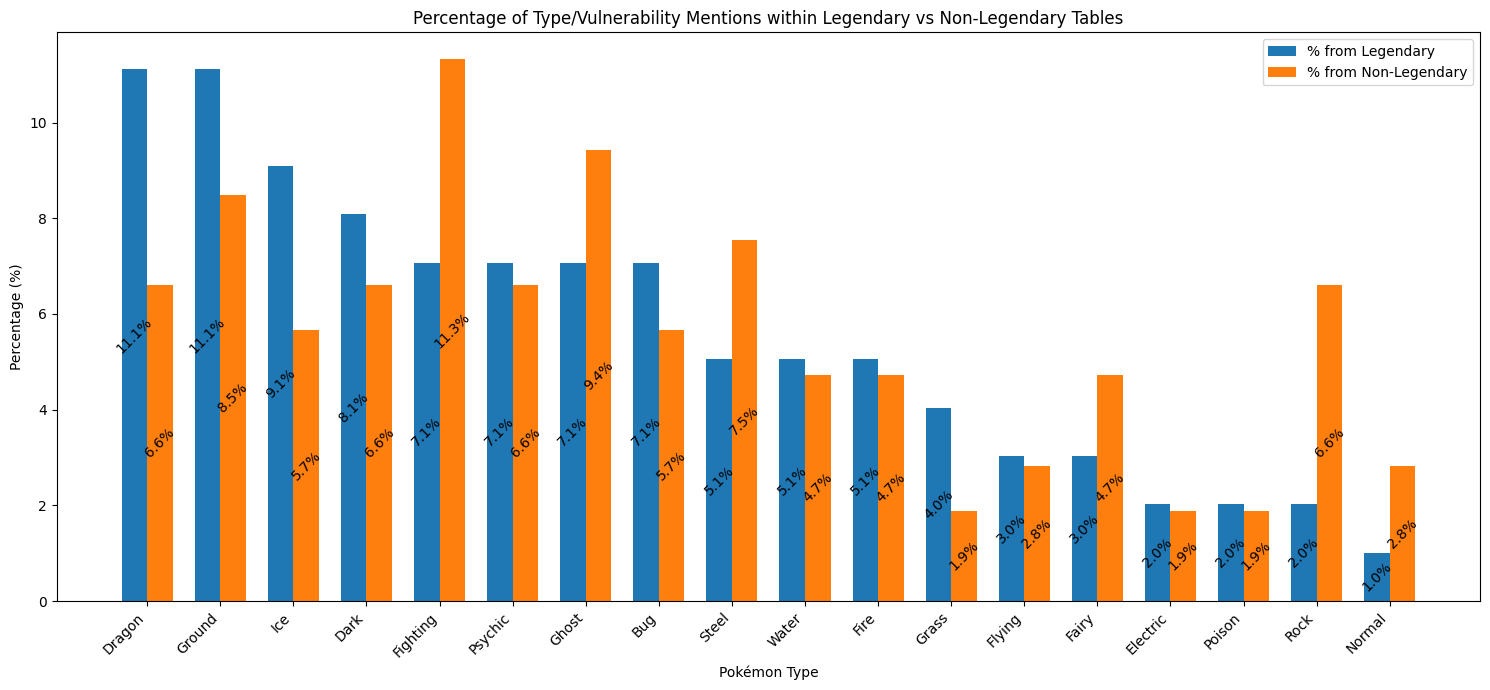

In [110]:
import matplotlib.pyplot as plt

# Calculate Total Mentions (Legendary) for each type
type_mention_comparison['Legendary Total Mentions'] = type_mention_comparison['Legendary Tables Mentions'] + type_mention_comparison['Legendary Vulnerability Mentions']

# Calculate Total Mentions (Non-Legendary) for each type
type_mention_comparison['Non-Legendary Total Mentions'] = type_mention_comparison['Non-Legendary Tables Mentions'] + type_mention_comparison['Non-Legendary Vulnerability Mentions']

# Calculate the overall total mentions for each type across both legendary and non-legendary tables
type_mention_comparison['Overall Total Mentions'] = type_mention_comparison['Legendary Total Mentions'] + type_mention_comparison['Non-Legendary Total Mentions']

# Calculate the total mentions across ALL types in legendary tables
total_legendary_mentions_all_types = type_mention_comparison['Legendary Total Mentions'].sum()

# Calculate the total mentions across ALL types in non-legendary tables
total_non_legendary_mentions_all_types = type_mention_comparison['Non-Legendary Total Mentions'].sum()

# Calculate Percentage from Legendary based on the total legendary mentions across all types (avoid division by zero)
type_mention_comparison['% from Legendary'] = (type_mention_comparison['Legendary Total Mentions'] / total_legendary_mentions_all_types).fillna(0) * 100

# Calculate Percentage from Non-Legendary based on the total non-legendary mentions across all types (avoid division by zero)
type_mention_comparison['% from Non-Legendary'] = (type_mention_comparison['Non-Legendary Total Mentions'] / total_non_legendary_mentions_all_types).fillna(0) * 100


# Sort by the percentage from legendary in descending order (or you can choose a different sorting)
type_mention_comparison = type_mention_comparison.sort_values(by='% from Legendary', ascending=False)


# Plot the legendary and non-legendary percentages side-by-side
plt.figure(figsize=(15, 7))
bar_width = 0.35
index = range(len(type_mention_comparison.index))

bars1 = plt.bar(index, type_mention_comparison['% from Legendary'], bar_width, label='% from Legendary')
bars2 = plt.bar([i + bar_width for i in index], type_mention_comparison['% from Non-Legendary'], bar_width, label='% from Non-Legendary')

plt.title('Percentage of Type/Vulnerability Mentions within Legendary vs Non-Legendary Tables')
plt.xlabel('Pokémon Type')
plt.ylabel('Percentage (%)')
plt.xticks([i + bar_width / 2 for i in index], type_mention_comparison.index, rotation=45, ha='right')
plt.legend()

# Add percentage labels on top of bars (optional, can be crowded)
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval / 2, f'{yval:.1f}%', ha='center', va='center', rotation=45) # Adjust vertical position and add rotation

plt.tight_layout()
plt.show()

### Conclusion 2: The Impact of Legendary Pokémon

Our analysis reveals that Legendary Pokémon have a significant impact on raw stats, the perception of the strongest types, and the overall fighting meta. The comparison of type and vulnerability mentions in the top Pokémon lists clearly shows a substantial shift when Legendary Pokémon are included versus when they are removed.

This indicates that while some types consistently perform well regardless of Legendary Pokémon, the presence of Legendaries can significantly elevate the prominence of certain types in top-tier competitive play due to their exceptional raw stats and unique type combinations and vulnerabilities. The data suggests that the meta game is indeed influenced by these powerful Pokémon, altering which types are most frequently seen among the strongest contenders.